In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# ================================ SETUP
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# import zipfile
# # Path to your zip file (change this)
# zip_file_path = 'drive/MyDrive/Colab Notebooks/lung_cancer.zip'
# extract_dir = 'drive/MyDrive/Colab Notebooks/lung_image_sets'

# # Unzip it
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

In [4]:
# DATA_DIR = extract_dir

In [5]:
# ================================ CONFIGURATION
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 8
EPOCHS_WARMUP = 5
EPOCHS_FINETUNE = 15
DATA_DIR = 'drive/MyDrive/Colab Notebooks/lung_image_sets'
MODEL_SAVE_PATH = 'drive/MyDrive/Colab Notebooks/final_mobilenet_lung_model_tf.keras'

In [6]:
# ================================ AUGMENTATION & PREPROCESSING
def preprocess(image, label, augment=False):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image,0.1, 0.3)
    return image, label

In [7]:
# ================================ LOAD DATA
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.


In [8]:
class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)

In [9]:
train_ds = raw_train_ds.map(lambda x, y: preprocess(x, y, augment=True)).shuffle(500).prefetch(1)


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
).map(lambda x, y: preprocess(x, y)).prefetch(1)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


In [11]:
# ================================ VISUALIZATION
print("📸 Displaying sample images before and after augmentation...")

original_images = []
original_labels = []
for image_batch, label_batch in raw_train_ds.take(1):
    for img, label in zip(image_batch, label_batch):
        original_images.append(tf.cast(img, tf.float32) / 255.0)
        class_index = int(tf.argmax(label))
        original_labels.append(class_index)
        if len(original_images) == 9:
            break

📸 Displaying sample images before and after augmentation...


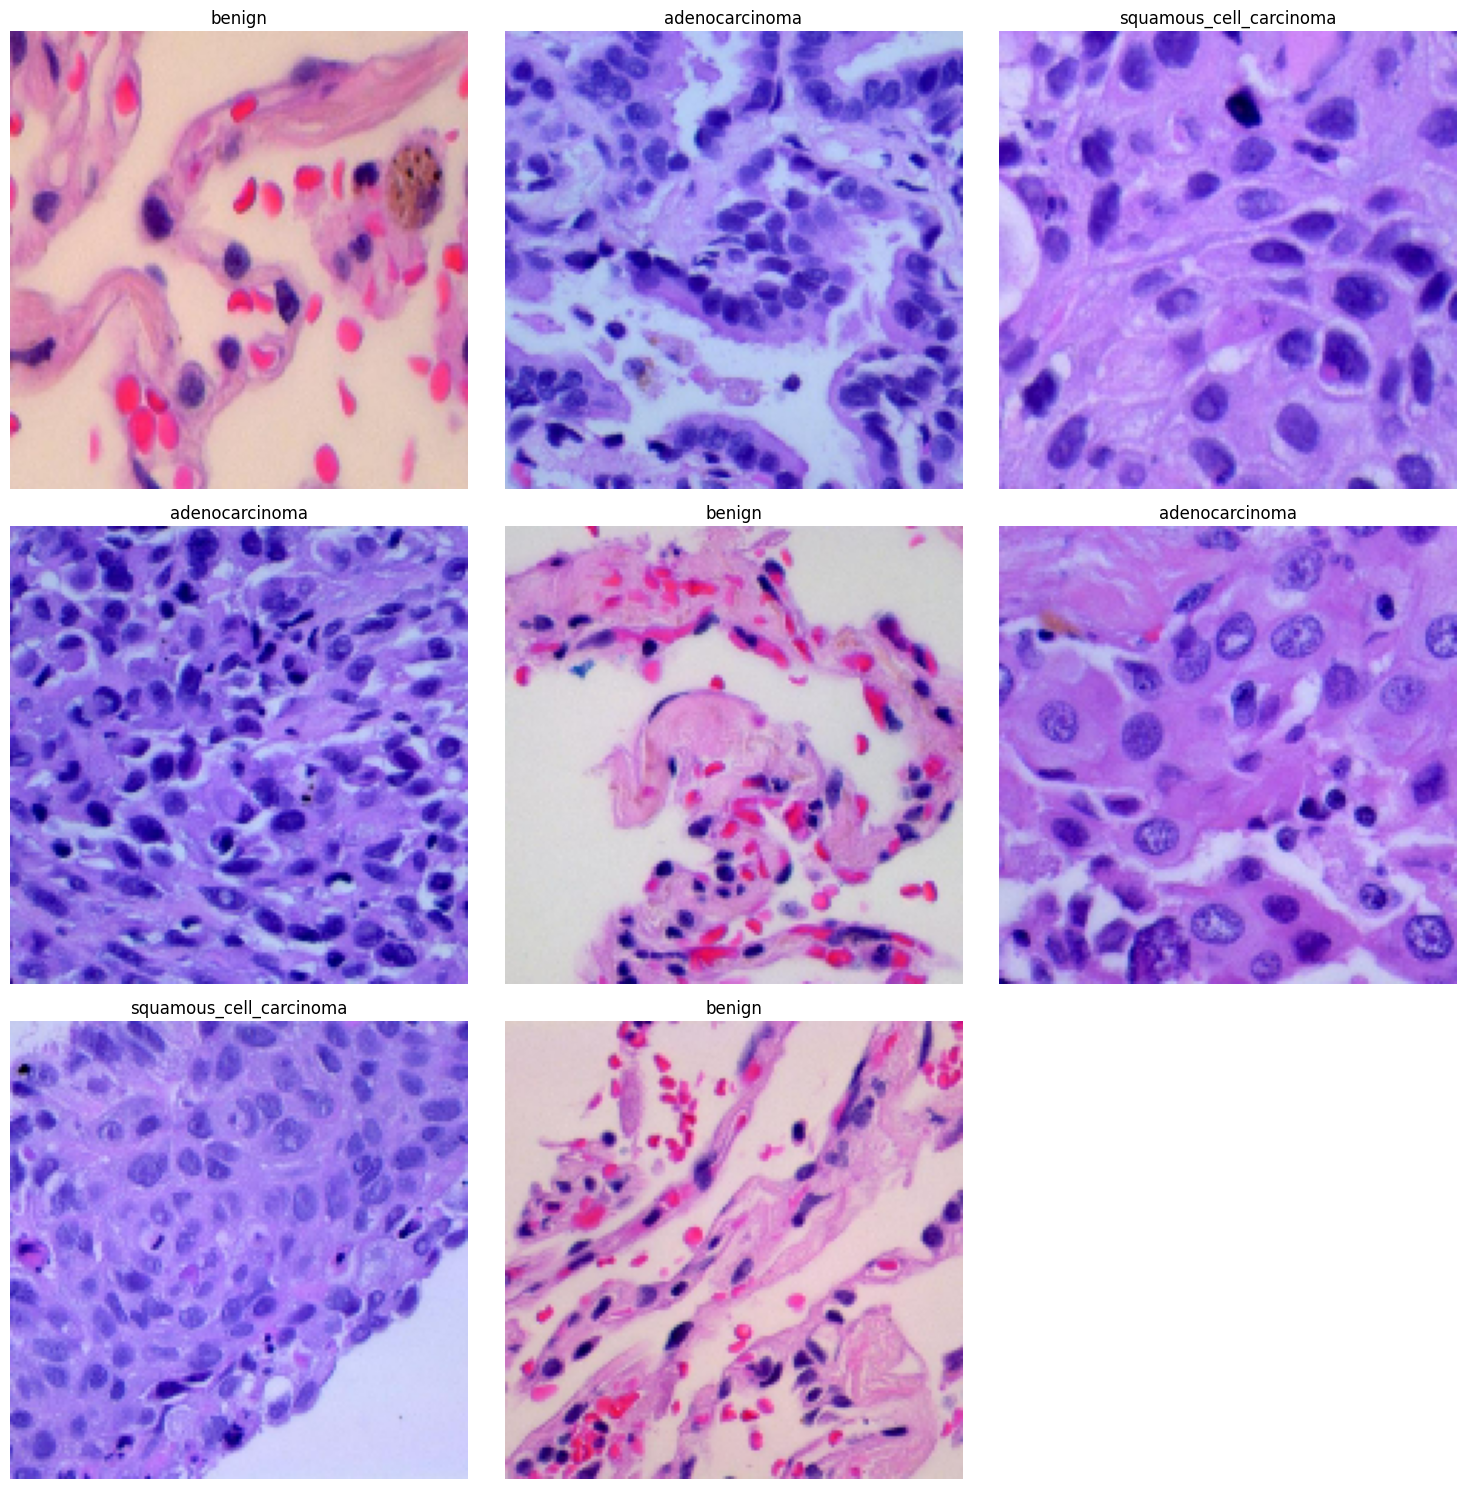

In [13]:
plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(3, 3, i + 1)
    plt.imshow(original_images[i])
    plt.title(class_names[original_labels[i]], fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

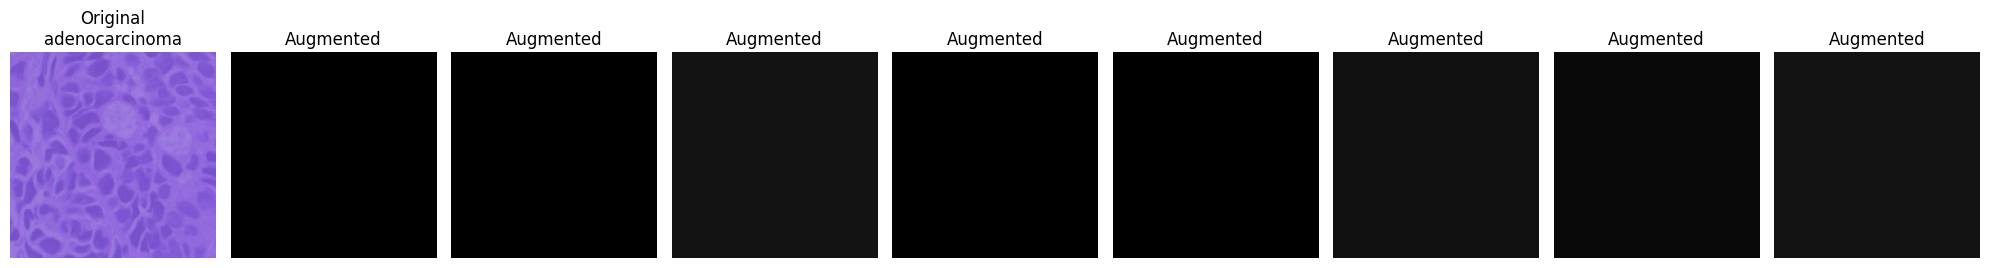

In [14]:
# Augmented versions
for images_batch, labels_batch in train_ds.take(1):
    original_image = images_batch[0]
    original_label = labels_batch[0]
    break
augmented_images = [preprocess(original_image, original_label, augment=True)[0] for _ in range(8)]

plt.figure(figsize=(20, 5))
plt.subplot(1, 9, 1)
plt.imshow(original_image)
plt.title(f"Original\n{class_names[np.argmax(original_label)]}")
plt.axis('off')

for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 9, i + 2)
    plt.imshow(tf.clip_by_value(aug_img, 0.0, 1.0))
    plt.title("Augmented")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# ================================ MODEL SETUP
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(160, 160, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# ================================ CALLBACKS
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [18]:
# ================================ WARM-UP TRAINING
print("🔥 Warm-up training...")
history_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_WARMUP,
    callbacks=[early_stop, reduce_lr]
)

🔥 Warm-up training...
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1172s 756ms/step - accuracy: 0.6323 - loss: 0.8171 - val_accuracy: 0.7093 - val_loss: 0.6122 - learning_rate: 1.0000e-04
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 403s 248ms/step - accuracy: 0.8337 - loss: 0.4007 - val_accuracy: 0.7873 - val_loss: 0.4751 - learning_rate: 1.0000e-04
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 443s 250ms/step - accuracy: 0.8648 - loss: 0.3260 - val_accuracy: 0.8470 - val_loss: 0.3674 - learning_rate: 1.0000e-04
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 451s 256ms/step - accuracy: 0.8798 - loss: 0.2998 - val_accuracy: 0.8777 - val_loss: 0.2823 - learning_rate: 1.0000e-04
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 435s 252ms/step - accuracy: 0.8887 - loss: 0.2799 - val_accuracy: 0.8647 - val_loss: 0.3152 - learning_rate: 1.0000e-04


In [19]:
# ================================ FINE-TUNING
print("🔓 Unfreezing top 30 layers of MobileNetV2...")
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


🔓 Unfreezing top 30 layers of MobileNetV2...


In [20]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 620s 385ms/step - accuracy: 0.8506 - loss: 0.3986 - val_accuracy: 0.6973 - val_loss: 2.2217 - learning_rate: 3.0000e-04
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 615s 389ms/step - accuracy: 0.9251 - loss: 0.1935 - val_accuracy: 0.5553 - val_loss: 4.5170 - learning_rate: 3.0000e-04
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 544s 344ms/step - accuracy: 0.9430 - loss: 0.1482 - val_accuracy: 0.8133 - val_loss: 0.9999 - learning_rate: 3.0000e-04
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 554s 347ms/step - accuracy: 0.9554 - loss: 0.1213 - val_accuracy: 0.6340 - val_loss: 5.6390 - learning_rate: 3.0000e-04
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9596 - loss: 0.1064
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 557s 348ms/step - accuracy: 0.9596 - loss: 0.1064 - val_accuracy: 0.7377 - val_loss: 2.3619 - learning_rate: 3.0000e-04
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━

In [21]:
# ================================ PLOT RESULTS
acc = history_warmup.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_warmup.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_warmup.history['loss'] + history_finetune.history['loss']
val_loss = history_warmup.history['val_loss'] + history_finetune.history['val_loss']

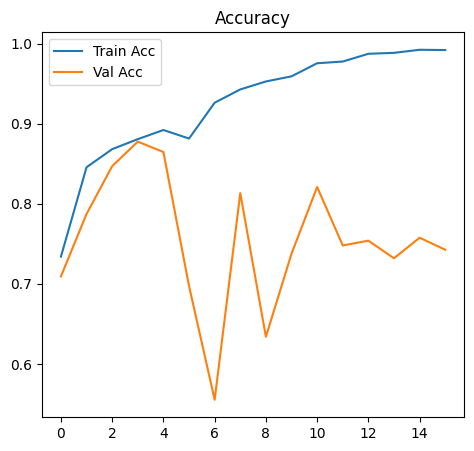

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()


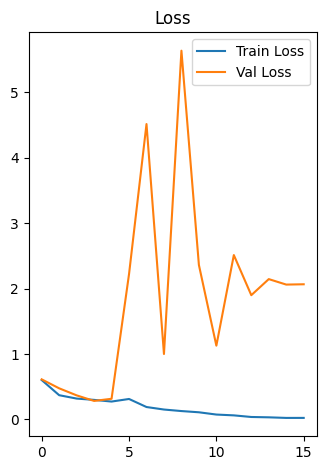

In [23]:
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# ================================ SAVE MODEL
model.save(MODEL_SAVE_PATH)
print(f"✅ Final model saved to: {MODEL_SAVE_PATH}")

✅ Final model saved to: drive/MyDrive/Colab Notebooks/final_mobilenet_lung_model_tf.keras


In [25]:
# ================================ MODEL SUMMARY
print("\n🧠 Model Summary:")
model.summary()



🧠 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,322,315 (20.30 MB)

 Trainable params: 1,530,243 (5.84 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 3,060,488 (11.67 MB)

In [26]:
# ================================ TEST SET & EVALUATION
print("\n📊 Evaluating model on test dataset...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
).map(lambda x, y: preprocess(x, y)).prefetch(1)



📊 Evaluating model on test dataset...
Found 15000 files belonging to 3 classes.


In [27]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 502s 268ms/step - accuracy: 0.8272 - loss: 1.0587
✅ Test Accuracy: 0.8305, Test Loss: 1.0368


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<ipython-input-28-52988e19e15e>:18: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


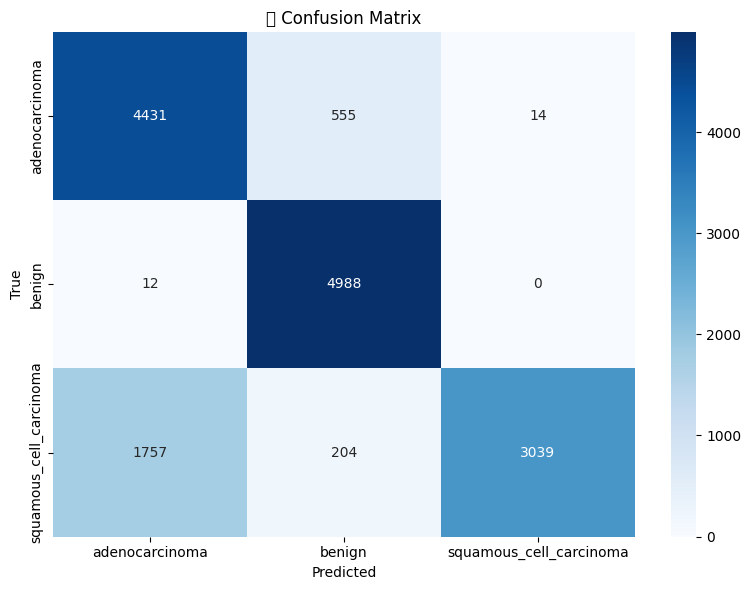

In [28]:
# ================================ CONFUSION MATRIX & CLASSIFICATION REPORT
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('🌀 Confusion Matrix')
plt.tight_layout()
plt.show()


In [29]:
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


📝 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.71      0.89      0.79      5000
                 benign       0.87      1.00      0.93      5000
squamous_cell_carcinoma       1.00      0.61      0.75      5000

               accuracy                           0.83     15000
              macro avg       0.86      0.83      0.82     15000
           weighted avg       0.86      0.83      0.82     15000

